In [1]:
#default_exp self_supervised

In [2]:
#export
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *

Loading imports


In [3]:
torch.cuda.set_device(2)

In [4]:
#export
def get_data_gen(fns, bs, img_tfm, splits, sz=None, nw=8, mean=mean, std=std, 
                 batch_xtra=None, after_item=None, with_aug=True, test=False, **kwargs):
    tfms = [[img_tfm, ToTensor]]
    if test: tfms = [tfms[0]]
    dsets = Datasets(fns, tfms, splits=splits)
    nrm = Normalize.from_stats(mean,std)
    batch_tfms = L(IntToFloatTensor, nrm) + L(batch_xtra)
#     if with_aug: batch_tfms += aug_transforms(**kwargs)
#     if sz is not None:
#         batch_tfms = batch_tfms+[RandomResizedCropGPU(sz, min_scale=0.7, ratio=(1.,1.))]
    return dsets.dataloaders(bs=bs, num_workers=nw, after_item=after_item, after_batch=batch_tfms)

In [5]:
Meta.df_comb

,Modality,PatientID,StudyInstanceUID,SeriesInstanceUID,StudyID,ImagePositionPatient,ImageOrientationPatient,SamplesPerPixel,PhotometricInterpretation,Rows,...,MultiWindowCenter,WindowCenter1,MultiWindowWidth,WindowWidth1,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
SOPInstanceUID,,,,,,,,,,,,,,,,,,,,,
ID_76d55d9d0,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_96d282ea9,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_7d8a7c29d,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_4d4401491,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_8f5ded0b7,CT,ID_b9797064,ID_00b9e1961f,ID_0000298a7d,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ID_8eb7c45bc,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_cf66e9f08,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0
ID_6c779d850,CT,ID_984a3f15,ID_7891a70bf4,ID_fffde5ed33,,-125.0,1.0,1,MONOCHROME2,512,...,NaN,NaN,NaN,NaN,0,0,0,0,0,0


In [6]:
#export
def get_data(bs, sz, splits, img_dir=path_jpg256, **kwargs):
    return get_data_gen(L(list(Meta.df_comb.index)), bs=bs, img_tfm=get_pil_fn(path/img_dir), 
                        sz=sz, splits=splits, **kwargs)

## Loss taken from here: https://github.com/adambielski/siamese-triplet/blob/master/losses.py

In [7]:
# Taken from this repo: 
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()


In [26]:
class ContrastiveCallback(Callback):
    def __init__(self):
        self.aug = RandomResizedCropGPU(size=256, min_scale=0.4, ratio=(1.,1.))
    def begin_batch(self): # fastai(v1) function = on_batch_begin
        xb, = self.learn.xb # (bs x w x h) -> (128 x 256 x 256)
        xb_aug = self.aug(xb) # (bs x w x h) -> (128 x 256 x 256)
        
        self.learn.xb = (torch.cat([xb, xb_aug]),) # (bs*2 x w x h) -> (256 x 256 x 256)
        self.bs = xb.shape[0]
        
    def after_pred(self): # fastai(v1) function = on_loss_begin
        xb_cat = self.learn.pred # (bs*2 x w x h) -> (256 x 256 x 256)
        xb = xb_cat[:self.bs] # (bs x w x h) -> (128 x 256 x 256)
        xb_aug = xb_cat[self.bs:] # (bs x w x h) -> (128 x 256 x 256)
        self.learn.pred = xb
        self.learn.yb = (xb_aug, xb_aug.flip(dims=[0]))
        

In [9]:
dls = get_data(128, 256, Meta.splits_sample)

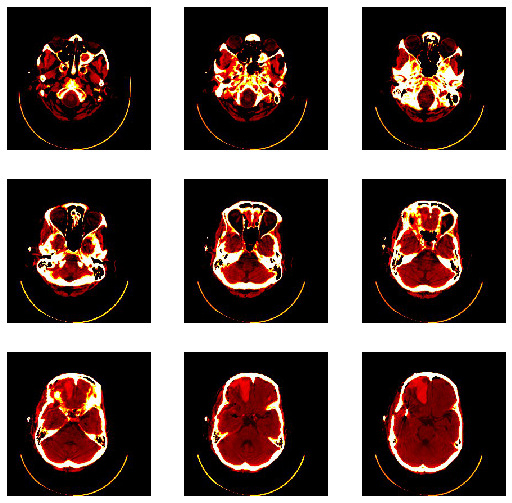

In [10]:
dls.valid.show_batch()

## Steps to get original data
* Step 1: Original data
* Step 2: augment/transform original data
* Step 3: flip batch
* Setp 4: contrastive loss

## Sanity Checking Triple loss

In [11]:
xb, = dls.one_batch()

In [12]:
tloss = TripletLoss(margin=0.5)

In [13]:
# Pos = Pos
tloss(xb, xb, xb.flip(dims=[0]))

tensor(0.3436, device='cuda:2')

In [14]:
# Pos = Neg
tloss(xb, xb.flip(dims=[0]), xb)

tensor(5.3176, device='cuda:2')

In [20]:
tloss(xb, aug(xb), xb.flip(dims=[0]))

tensor(4.2300, device='cuda:2')

In [15]:
aug = RandomResizedCropGPU(256, min_scale=0.3, ratio=(1.,1.))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


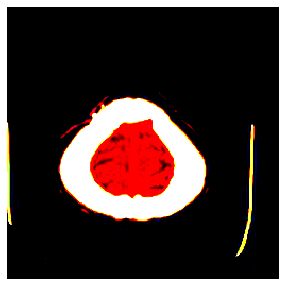

In [19]:
show_image(aug(xb)[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


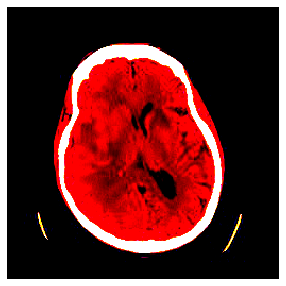

In [17]:
show_image(xb.flip(dims=[0])[0])

## Training

In [27]:
learn = Learner(dls, xresnet18(), loss_func=TripletLoss(0.5), lr=3e-3,
            opt_func=Adam, metrics=[], cbs=ContrastiveCallback)

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,time
0,0.538815,0.168306,01:34


## Export

In [1]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_metadata.ipynb.
Converted 01_preprocess.ipynb.
Converted 01_preprocess_mean_std.ipynb.
Converted 02_train.ipynb.
Converted 02_train_01_save_features.ipynb.
Converted 03_train3d.ipynb.
Converted 04_trainfull3d_deprecated.ipynb.
Converted 04_trainfull3d_labels.ipynb.
Converted 05_train_adjacent.ipynb.
Converted 06_seutao_features.ipynb.
Converted Tabular_02_FeatureImportance.ipynb.
Converted Untitled.ipynb.
